In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os


In [3]:
print(os.listdir("/gdrive/My Drive/Kidney Cancer"))

['Tumor', 'Normal']


In [4]:
DATADIR = "/gdrive/My Drive/Kidney Cancer"

CATEGORIES = ["Normal","Tumor"]

In [5]:
IMG_SIZE = 100

In [6]:
all_data =[]

def create_all_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                all_data.append([new_array,class_num])
            except Exception as e:
                pass
create_all_data()

In [7]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  10000


In [8]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [11]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(7200, 100, 100, 3)
(2000, 100, 100, 3)
(800, 100, 100, 3)
(7200,)
(2000,)
(800,)


In [12]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [13]:

from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(64, (3,3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [14]:
from tensorflow import keras

callback_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor = 'val_accuracy', save_best_only=True, verbose=3
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=3)
]

In [15]:
history = model.fit(x_train, train_yCl,
                    batch_size=64,
                    validation_data = (x_val, valid_yCl),
                    callbacks = callback_list,
                    epochs = 50
                    )

Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.9014
Epoch 1: val_accuracy improved from -inf to 0.55500, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - 901s 8s/step - loss: 0.6083 - accuracy: 0.9014 - val_loss: 5.1307 - val_accuracy: 0.5550
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9867
Epoch 2: val_accuracy improved from 0.55500 to 0.96000, saving model to model.h5
113/113 [==============================] - 906s 8s/step - loss: 0.0394 - accuracy: 0.9867 - val_loss: 0.1194 - val_accuracy: 0.9600
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9837
Epoch 3: val_accuracy improved from 0.96000 to 0.99625, saving model to model.h5
113/113 [==============================] - 899s 8s/step - loss: 0.0671 - accuracy: 0.9837 - val_loss: 0.0061 - val_accuracy: 0.9962
Epoch 4/50
113/113 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9949
Epoch 4: val_accuracy improved from 0.99625 to 0.99750, saving model to model.h5
113/113 [==============================] - 899s 8s/step - loss: 0.0159 - 

In [16]:
score_valid = model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = model.evaluate(x_test, test_yCl)
print("Validation Accuracy: ", score_test[1])

score_train = model.evaluate(x_train, train_yCl)
print("Validation Accuracy: ", score_train[1])

25/25 [==============================] - 27s 1s/step - loss: 0.0674 - accuracy: 0.9787
Validation Accuracy:  0.9787499904632568
63/63 [==============================] - 68s 1s/step - loss: 0.0855 - accuracy: 0.9745
Validation Accuracy:  0.9745000004768372
225/225 [==============================] - 233s 1s/step - loss: 0.0702 - accuracy: 0.9785
Validation Accuracy:  0.9784722328186035


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Test verisi üzerinde tahminlerde bulunun
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Gerçek sınıfları alın
y_true_classes = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1-Score: {f1}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)


63/63 [==============================] - 65s 1s/step
Accuracy: 0.9745
Precision: 0.9745033532544822
Recall: 0.9745
F1-Score: 0.9744994835308735
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1012
           1       0.98      0.97      0.97       988

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

Confusion Matrix:
[[988  24]
 [ 27 961]]


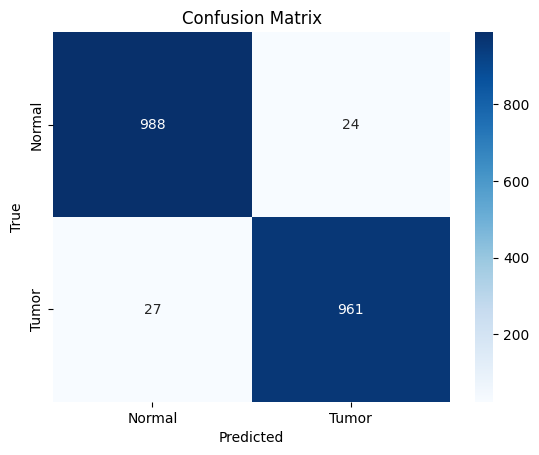

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [19]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.3 MB/s eta 0:00:00


In [20]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from keras.layers import Conv2D
from tensorflow.keras import layers

# Define your model-building function
def build_model(hp):
    model = keras.Sequential()

    model.add(Conv2D(64, (3,3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    directory='hyperparameter_tuning',
    project_name='cnn_tuning'
)

# Perform the hyperparameter search
tuner.search(x_train, train_yCl, validation_data=(x_val, valid_yCl), epochs=3)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

# Evaluate the best model on test data
test_score = best_model.evaluate(x_test, test_yCl)
print("Best Model Test Accuracy:", test_score[1])

# Display the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)

# Display tuner results summary
tuner.results_summary()

Trial 1 Complete [00h 47m 25s]
val_accuracy: 0.9987499713897705

Best val_accuracy So Far: 0.9987499713897705
Total elapsed time: 00h 47m 25s
63/63 [==============================] - 65s 1s/step - loss: 0.0041 - accuracy: 0.9985
Best Model Test Accuracy: 0.9984999895095825
Best Hyperparameters:
{'learning_rate': 0.00013791901033001646}
Results summary
Results in hyperparameter_tuning/cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
learning_rate: 0.00013791901033001646
Score: 0.9987499713897705
